## Check visibility (first hit) using custom camera projection

User defined rays pointing to a particle set to allow visibility test on a bunch of directions.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
from plotoptix import NpOptiX

Callback function used to extract hit info. See [rt._geo_id_format](https://plotoptix.rnd.team/npoptix_config.html#plotoptix.NpOptiX._geo_id) for a complete info on data stored in this buffer.

In [2]:
def update_image(rt: NpOptiX) -> None:
    points_id = rt.geometry_data["points"]._handle
    f = rt._geo_id[:,:,0].reshape(rt._height, rt._width)
    f &= 0x3FFFFFFF # remove the vertex id info (bits 30 and 31)
    visible = f == points_id
    invisible = (f != points_id) * (f < 0x3FFFFFFF)
    empty = f == 0x3FFFFFFF
    f[visible] = 2
    f[invisible] = 1
    f[empty] = 0
    img.set_data(f)
    img.set_clim(vmin=0, vmax=2)
    plt.draw()

Setup the raytracer:

In [3]:
width = 400
height = 300

rt = NpOptiX(on_launch_finished=update_image, width=width, height=height, start_now=False)

# NOTE: no need for multiple passes, set up just 1 pass:
rt.set_param(min_accumulation_step=1, max_accumulation_frames=1)

Read the mesh. Use a simple, flat shading material if the face id is the only interesting thing (so no secondary rays are traced).

In [4]:
from plotoptix.materials import m_flat

rt.setup_material("flat", m_flat)

rt.load_mesh_obj("data/utah-teapot.obj", mat="flat")

Add a set of small radii points. We're going to shoot rays towards each of these points later. Particles here are for the visualization purpose, in general, there is no need for a gemetry object on the ray direction. 

In [5]:
u = np.linspace(-50, 50, width)
v = np.linspace(50, -50, height)
V, U = np.meshgrid(v, u)

xyz = np.stack((U, V, np.full((width, height), -15))).T

# optionally randomize positions - to see that rays really can follow set of irregular directions
xyz += 0.2 * np.random.rand(height, width, 3)

rt.set_data("points", xyz, r=0.1, mat="flat")

Start with ray angles encoding the usual perspective projection.

In [6]:
fov = 45 # field of view (vertical), in degrees

# equirectangular projection
a_ratio = width / height
u = np.linspace(-0.5 * a_ratio * fov / 180, 0.5 * a_ratio * fov / 180, width)
v = np.linspace(0.5 * fov / 180, -0.5 * fov / 180, height)

V, U = np.meshgrid(v, u)

fi_tex = np.stack((U, V)).T

rt.set_texture_2d("fi_tex", fi_tex)

Setup camera:

In [7]:
eye = np.array([20.0, 50.0, 100.0])
target = np.array([0.0, 0.0, 0.0])
up = np.array([0.0, 1.0, 0.0])
rt.setup_camera("cam1", cam_type="CustomProj",
                eye=eye, target=target, up=up,
                textures=["fi_tex"])

Show the output image here:

<IPython.core.display.Javascript object>


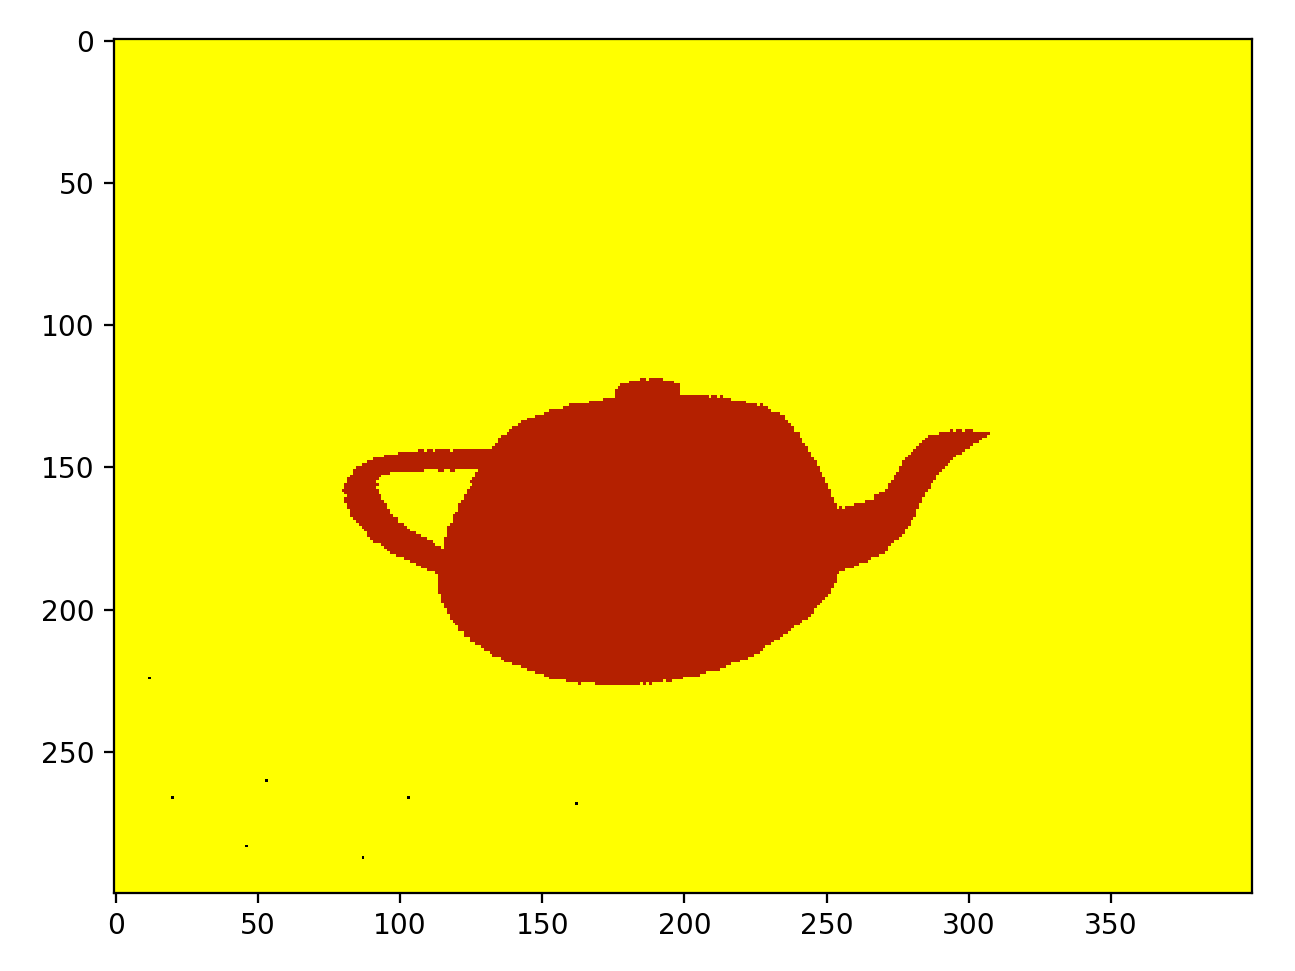

In [8]:
plt.figure(1)
img = plt.imshow(np.zeros((height,width,4)), cmap=plt.get_cmap("gnuplot"))
plt.tight_layout()

Start the ray tracing:

In [9]:
rt.start()

Modify the projection angles - now each ray will point towards one primitive in the particle set.

Custom projection is defined with ray angles in a texture. If the texture size coincides with the render view size, exactly each ray is defined by corresponding pixel in the texture, otherwise ray angles are interpolated. Ray angles are:
- u, horizontal deflection with respect to the camera axis (negative to the left, positive to the right)
- v, vertical deflection with respect to the camera axis (negative down, positive up).

Angles are in radians, scaled to map the range `(-pi;  pi)` to `(-1; 1)`.

In [10]:
forward = target - eye
forward /= np.linalg.norm(forward)

up -= np.dot(forward, up) * forward
up /= np.linalg.norm(up)

right = np.cross(forward, up)

# not so pythonic, but instead very explicit math:
fi_tex2 = np.zeros((height, width, 2))
for iv in range(height):
    for iu in range(width):
        p = xyz[iv,iu] - eye
        
        pn = np.dot(p, right) * right
        pv = p - pn                         # eye->point vector projected on the camera "vertical" plane
        cv = np.dot(forward, pv/np.linalg.norm(pv))
        v = np.arccos(cv) * np.sign(np.dot(pv, up))
        
        pn = np.dot(p, up) * up
        pu = p - pn                         # eye->point vector projected on the camera "horizontal" plane
        cu = np.dot(forward, pu/np.linalg.norm(pu))
        u = np.arccos(cu) * np.sign(np.dot(pu, right))
        
        fi_tex2[iv,iu,0] = u
        fi_tex2[iv,iu,1] = v

fi_tex2 *= 1.0/np.pi

Update the camera texture content.

Now the image background should turn completely yellow - each ray points to one particle. The red shadow of the pot shows the area where rays do not reach particles. If there are black dots, it means particle radii where too small for the camera distance and the math precision was not enough to point to the particle precisely (and the ray hits empty space).

In [11]:
rt.set_texture_2d("fi_tex", fi_tex2, refresh=True)

Close the ray-tracer.

In [12]:
rt.close()